# Assessment of nephrotoxicity of vancomycin

The aim of this study was to quantify the association between nephrotoxicity and vancomycin in a large, multi-center US database.
The study matches patients who were admitted to the emergency department and received vancomycin on ICU admission versus those who did not receive vancomycin on admission. The matching is done using a propensity score built using the following covariates:

* presence of sepsis or septic shock
  * SIRS, lactate, elevated WBC, hypotension, fever
* soft tissue infection/skin infections (?cellulitis, or APACHE admission diagnosis Sepsis:skin)
* risk factors for community acquired MRSA
* risk factors for MDR in general (hospitalization for more than 48 hours in the last 90 days, residence in a nursing home or extended care facility, home infusion therapy, chronic dialysis within one month, home wound care)
* known colonization with MRSA
* immunocompromized state even in the absence of shock (probably captured through the comorbidity fields)

## Definitions

* **drug on admission:** patient received medication order -12 to 12 hours upon admission to the ICU
* **baseline creatinine:** first creatinine value between -12 to 12 hours upon admission to the ICU
* **AKI:** following KDIGO guidelines using only creatinine, any instance of AKI between 2-7 days after their ICU admission.

KDIGO guidelines for AKI are: >= 50% change from baseline over 7 days, or absolute increase of 0.3 in creatinine over 48 hours.

## 0. Setup

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
import pymatch
from pymatch.Matcher import Matcher

%matplotlib inline

# helper functions stored in local py file
import utils

# Helper function to read data from database
conn_info = "host='localhost' dbname='eicu' user='alistairewj' port=5432"
con = psycopg2.connect(conn_info)

def run_query(query):
    return pd.read_sql_query(query, con)

# 1. Summarize cohort

In [2]:
co = run_query("select * from vanco.cohort")

In [3]:
print('== EXCLUSIONS - TOTAL ==')
N = co.shape[0]
print(f'{N:6d} unique unit stays.')
for c in co.columns:
    if c.startswith('exclude_'):
        N = co[c].sum()
        mu = co[c].mean()*100.0
        print(f'  {N:6d} ({mu:4.1f}%) - {c}')
        
print('\n== EXCLUSIONS - SEQUENTIAL ==')
N = co.shape[0]
print(f'{N:7d} unique unit stays.')
idx = co['patientunitstayid'].notnull()
for c in co.columns:
    if c.startswith('exclude_'):
        # index patients removed by this exclusion
        idxRem = (co[c]==1)
        # calculate number of patients being removed, after applying prev excl
        N = (idx & idxRem).sum()
        mu = N/co.shape[0]*100.0
        idx = idx & (~idxRem)
        n_rem = idx.sum()
        
        print(f'- {N:5d} = {n_rem:6d} ({mu:4.1f}% removed) - {c}')

== EXCLUSIONS - TOTAL ==
200859 unique unit stays.
       0 ( 0.0%) - exclude_before_2005
   25239 (12.6%) - exclude_sdu
    4930 ( 2.5%) - exclude_short_stay
  111265 (55.4%) - exclude_non_ed_admit
   12280 ( 6.1%) - exclude_secondary_stay
   33622 (16.7%) - exclude_no_med_interface
    8059 ( 4.0%) - exclude_dialysis_chronic
   18265 ( 9.1%) - exclude_dialysis_first_week
   31408 (15.6%) - exclude_cr_missing_baseline
   72199 (35.9%) - exclude_cr_missing_followup

== EXCLUSIONS - SEQUENTIAL ==
 200859 unique unit stays.
-     0 = 200859 ( 0.0% removed) - exclude_before_2005
- 25239 = 175620 (12.6% removed) - exclude_sdu
-  3286 = 172334 ( 1.6% removed) - exclude_short_stay
- 87643 =  84691 (43.6% removed) - exclude_non_ed_admit
- 11597 =  73094 ( 5.8% removed) - exclude_secondary_stay
- 14907 =  58187 ( 7.4% removed) - exclude_no_med_interface
-  2235 =  55952 ( 1.1% removed) - exclude_dialysis_chronic
-  3341 =  52611 ( 1.7% removed) - exclude_dialysis_first_week
-  3199 =  49412 ( 

# 3. Analysis


## Get data from database

In [4]:
# covariates from APACHE table
dem = run_query("SELECT dem.* FROM vanco.demographics dem")

# vancomycin drug doses
v = run_query("SELECT v.* FROM vanco.vanco v")

# AKI
query = """
SELECT 
  patientunitstayid
  , chartoffset
  , creatinine, creatinine_reference, creatinine_baseline
  , aki_48h, aki_7d
FROM vanco.aki
"""
aki = run_query(query)

In [5]:
# APACHE
query = """
SELECT 
  patientunitstayid
  , apache_prob
  , immunocompromised
FROM vanco.apache
"""
apache = run_query(query)

# convert apache predictions into numeric
apache['apache_prob'] = pd.to_numeric(apache['apache_prob'])

# sepsis/infection/organ failure
query = """
SELECT 
  patientunitstayid
  , sepsis
  , infection
  , organfailure
  , infection_skin_soft_tissue
FROM vanco.sepsis_infection
"""
dx = run_query(query)

## Collapse vancomycin data

The `v` dataframe has every vancomycin administration for a patient.

Here we collapse it into two binary columns:

* 'vanco_adm' - vancomycin was administered on ICU admission (between hours -12 and 12)
* 'vanco_wk' - vancomycin was administered sometime between 2-7 days after ICU admission

In [6]:
v_df = utils.extract_adm_and_wk(v, 'vanco')

Print out the proportion of patients with/without vancomycin after exclusions.

In [7]:
# get patient unit stay ID after applying exclusions
idxKeep = co['patientunitstayid'].notnull()
for c in co.columns:
    if c.startswith('exclude_'):
        idxKeep = idxKeep & (co[c]==0)
        
ptid = co.loc[idxKeep, 'patientunitstayid'].values
n_pt = len(ptid)
# limit to those in vancomycin dataframe
ptid = [x for x in ptid if x in v_df.index]

N = len(ptid)
print(f'{n_pt} stays after exclusions.')
for c in v_df.columns:
    N = v_df.loc[ptid, c].sum()
    mu = N / n_pt * 100.0
    print(f'  {N} ({mu:3.1f}%) with {c}')
    
# if they have both adm, then row-wise sum must be greater than 1
N = (v_df.loc[ptid, :] == 1).sum(axis=1)
N = (N>1).sum()
mu = N / n_pt * 100.0
print(f'  {N} ({mu:3.1f}%) with both')

28516 stays after exclusions.
  4609 (16.2%) with vanco_adm
  3901 (13.7%) with vanco_wk
  2204 (7.7%) with both


## Create a dataframe for analysis

The below code block:

* Applies exclusions
* Adds vancomycin binary flags
* Adds AKI flag

In [32]:
# drop exclusions
idxKeep = co['patientunitstayid'].notnull()
for c in co.columns:
    if c.startswith('exclude_'):
        idxKeep = idxKeep & (co[c]==0)

# combine data into single dataframe
df = co.loc[idxKeep, ['patientunitstayid']].merge(dem, how='inner', on='patientunitstayid')

# add vanco administration
df = df.merge(v_df, how='left', on='patientunitstayid')

# if ptid missing in vanco dataframe, then no vanco was received
# therefore impute 0
for c in v_df.columns:
    df[c].fillna(0, inplace=True)
    df[c] = df[c].astype(int)

aki_grp = aki.groupby('patientunitstayid')[['creatinine', 'aki_48h', 'aki_7d']].max()
aki_grp.reset_index(inplace=True)
df = df.merge(aki_grp, how='inner', on='patientunitstayid')

df['aki'] = ((df['aki_48h'] == 1) | (df['aki_7d'] == 1)).astype(int)

# add in apache/diagnosis data
df = df.merge(apache, how='left', on='patientunitstayid')
for c in apache.columns:
    if c != 'apache_prob':
        df[c].fillna(0, inplace=True)
        df[c] = df[c].astype(int)
df = df.merge(dx, how='left', on='patientunitstayid')
for c in dx.columns:
    df[c].fillna(0, inplace=True)
    df[c] = df[c].astype(int)

df['sepsis_all'] = (df['sepsis'] == 1) | ((df['infection'] == 1) & (df['organfailure'] == 1))
df['sepsis_all'] = df['sepsis_all'].astype(int)

# convert binary vars to string so they are interpreted as categorical
for c in ['immunocompromised', 'sepsis_all', 'infection_skin_soft_tissue']:
    df[c] = df[c].map({0: 'no', 1: 'yes'})

# avoid conflicts in column names with pymatch
df.rename(columns={'weight': 'weight_kg', 'height': 'height_cm'}, inplace=True)

# ensure apache/age are continuous
idx = df['age'] == '> 89'
df.loc[idx, 'age'] = 90
df['age'] = df['age'].astype(int)

idx = df['apachescore'] == -1
df.loc[idx, 'apachescore'] = np.nan
df['apachescore'] = df['apachescore'].astype(float)

idx = df['apache_group'] == '-1'
df.loc[idx, 'apache_group'] = 'missing'

# set patientunitstayid as index
df.set_index('patientunitstayid', inplace=True)
df.sort_index(inplace=True)
print(df.shape)
df.head()

(28516, 22)


,unitdischargeoffset,age,gender,weight_kg,height_cm,bmi,bmi_group,apachescore,apache_group,vanco_adm,...,aki_48h,aki_7d,aki,apache_prob,immunocompromised,sepsis,infection,organfailure,infection_skin_soft_tissue,sepsis_all
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
141197,74,71,Male,102.10,162.6,39.0,overweight,NaN,None,0,...,0,0,0,NaN,no,1,0,0,no,yes
141288,1631,61,Female,83.69,162.6,32.0,overweight,33.0,31-40,1,...,0,0,0,0.026199,no,1,1,1,no,yes
141360,3109,48,Male,91.35,175.3,30.0,overweight,22.0,21-30,0,...,0,0,0,0.029281,no,0,0,0,no,no
141392,961,78,Female,90.80,160.0,35.0,overweight,35.0,31-40,0,...,0,0,0,0.021379,no,1,1,1,no,yes
141436,2167,46,Male,69.95,167.6,25.0,overweight,56.0,51-60,0,...,0,0,0,0.108486,no,0,0,1,no,no


## Propensity matching

In [29]:
# pymatch complains a lot!
warnings.filterwarnings('ignore')

In [30]:
# Vanco + No Vanco Analysis
print('\n=== Cross-tabulation of vanco on admission vs. vanco during the week (days 2-7) ===')
display(pd.crosstab(df['vanco_adm'], df['vanco_wk'], margins=True))
print('Normalized:')
display(pd.crosstab(df['vanco_adm'], df['vanco_wk'], margins=True, normalize=True))


=== Cross-tabulation of vanco on admission vs. vanco during the week (days 2-7) ===


vanco_wk,0,1,All
vanco_adm,,,
0,22210,1697,23907
1,2405,2204,4609
All,24615,3901,28516


Normalized:


vanco_wk,0,1,All
vanco_adm,,,
0,0.778861,0.05951,0.838371
1,0.084339,0.07729,0.161629
All,0.863200,0.13680,1.000000


Our first (preliminary) propensity score will use only APACHE-IV as the covariate.

In [33]:
# INITIAL VANCO vs. NO VANCO
test = df[(df['vanco_adm'] == 1)].copy()
control = df[(df['vanco_wk'] == 0) & (df['vanco_adm'] == 0)].copy()
test['vanco_status'] = 1
control['vanco_status'] = 0

# vars we retain:
cols = ['vanco_status', 'age', 'apache_prob', 'sepsis', 'infection_skin_soft_tissue', 'immunocompromised']
cols_exclude = [c for c in test.columns if c not in cols]

print('Dataframe being used:')
display(test[cols].head())

m = Matcher(test, control, yvar="vanco_status", exclude=cols_exclude)

Dataframe being used:


,vanco_status,age,apache_prob,sepsis,infection_skin_soft_tissue,immunocompromised
patientunitstayid,,,,,,
141288,1,61,0.026199,1,no,no
141751,1,60,NaN,1,no,no
141771,1,52,0.243177,0,no,no
142002,1,59,0.513290,0,no,no
142209,1,73,0.128382,1,no,no


Formula:
vanco_status ~ age+apache_prob+immunocompromised+sepsis+infection_skin_soft_tissue
n majority: 19500
n minority: 4149


In [34]:
np.random.seed(94020)
# predict the y outcome balancing the classes
# repeat 100 times to be sure we use a lot of majority class data
m.fit_scores(balance=True, nmodels=10)

Fitting Models on Balanced Samples: 10\10
Average Accuracy: 73.37%


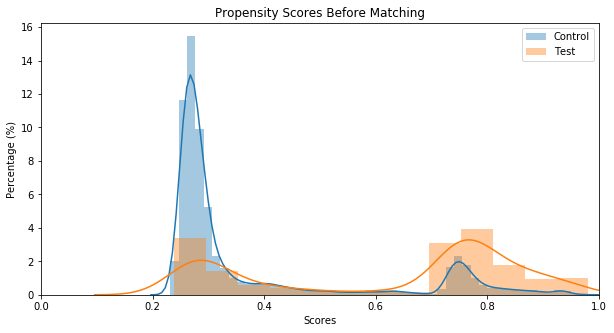

In [35]:
m.predict_scores()
m.plot_scores()

Determine the best caliper for matching scores.

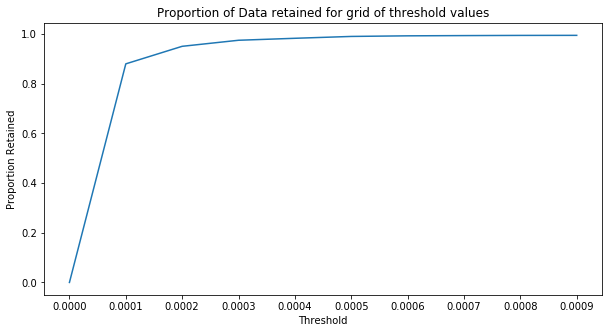

In [36]:
m.tune_threshold(method='random')

The above tells us that a calpier of 0.0005 will allow ~100% of data to be matched.

Next we allow for sampling with replacement using the above threshold of 0.0005.

In [37]:
m.match(method="min", nmatches=1, threshold=0.0005)
m.record_frequency()

,freq,n_records
0,1,6302
1,2,478
2,3,184
3,4,67
4,5,22
5,6,12
6,7,2
7,8,3


Generate a weight vector accounting for sampling with replacement.

In [38]:
m.assign_weight_vector()

`m` has also assigned a match_id to each record indicating paired matches (since we use nmatches=1). We can verify that matched records have scores within 0.0005 of each other.



In [39]:
m.matched_data.sort_values("match_id").head(n=6)

,record_id,weight,unitdischargeoffset,age,gender,weight_kg,height_cm,bmi,bmi_group,apachescore,...,apache_prob,immunocompromised,sepsis,infection,organfailure,infection_skin_soft_tissue,sepsis_all,vanco_status,scores,match_id
0,0,1.0,1631,61,Female,83.69,162.6,32.0,overweight,33.0,...,0.026199,no,1,1,1,no,yes,1,0.735148,0
4839,7798,0.5,2461,67,Female,79.90,160.0,31.0,overweight,52.0,...,0.040434,no,1,1,1,no,yes,0,0.735174,0
1,2,1.0,7999,52,Female,62.79,165.1,23.0,normal,99.0,...,0.243177,no,0,0,0,no,no,1,0.369541,1
8052,25307,1.0,16043,80,Female,79.00,167.0,28.0,overweight,61.0,...,0.309296,no,0,0,0,no,no,0,0.369531,1
2,3,1.0,3897,59,Male,85.71,177.8,27.0,overweight,87.0,...,0.513290,no,0,0,0,no,no,1,0.500564,2
8007,24997,1.0,1998,72,Male,79.30,188.0,22.0,normal,95.0,...,0.543986,no,0,0,1,no,no,0,0.500563,2


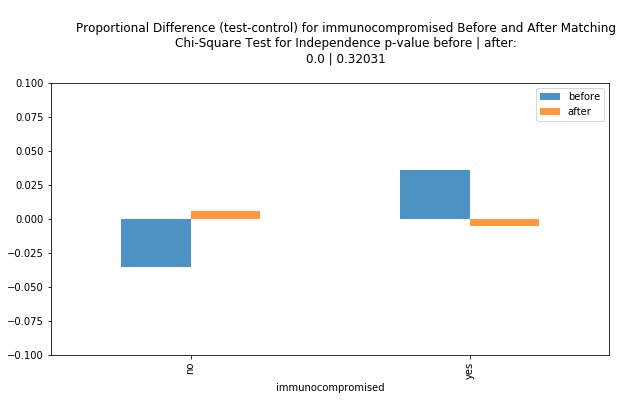

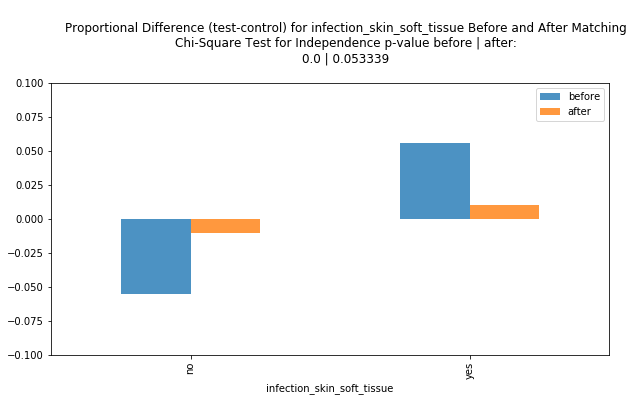

In [41]:
# no categorical variables -> this errors
categorical_results = m.compare_categorical(return_table=True)

,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.0,0.248,0.001,0.033,0.057802,0.000000,0.063782,0.008098
1,apache_prob,0.0,0.160,1.000,1.000,0.297223,-0.001064,0.376533,-0.041233
2,sepsis,0.0,0.864,1.000,1.000,2.356519,0.000000,1.071542,0.003952


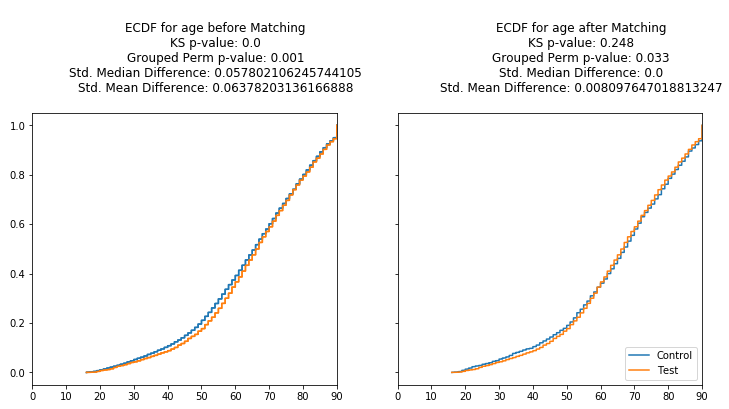

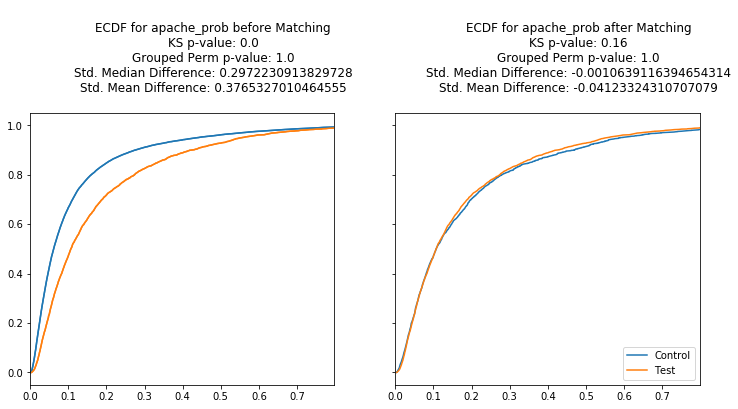

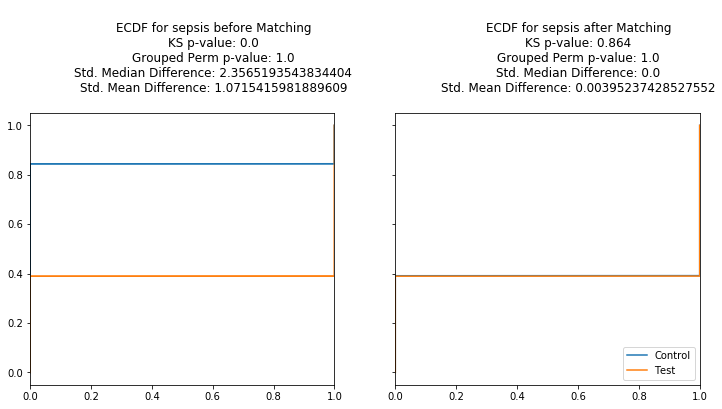

In [42]:
cc = m.compare_continuous(return_table=True)
display(cc)

In [43]:
# now grab the matched data into a single dataframe
m_control = m.matched_data.loc[m.matched_data['vanco_status']==0].copy()
m_exposure = m.matched_data.loc[m.matched_data['vanco_status']==1].copy()


df_matched = m_control.merge(m_exposure, how='left', on='match_id',
                             suffixes=('_control', '_exposure'))

print(df_matched.shape)

df_matched.head()

(4149, 53)


,record_id_control,weight_control,unitdischargeoffset_control,age_control,gender_control,weight_kg_control,height_cm_control,bmi_control,bmi_group_control,apachescore_control,...,aki_exposure,apache_prob_exposure,immunocompromised_exposure,sepsis_exposure,infection_exposure,organfailure_exposure,infection_skin_soft_tissue_exposure,sepsis_all_exposure,vanco_status_exposure,scores_exposure
0,4610,1.0,3109,48,Male,91.35,175.3,30.0,overweight,22.0,...,0,0.055275,no,0,1,0,no,no,1,0.275501
1,4611,0.5,961,78,Female,90.80,160.0,35.0,overweight,35.0,...,0,0.036058,no,1,1,1,no,yes,1,0.716400
2,4611,0.5,961,78,Female,90.80,160.0,35.0,overweight,35.0,...,0,0.024486,no,1,1,1,no,yes,1,0.716510
3,4623,1.0,778,82,Female,47.67,154.9,20.0,normal,41.0,...,1,0.029518,no,1,1,1,no,yes,1,0.721695
4,4629,1.0,2586,65,Male,129.31,182.9,39.0,overweight,83.0,...,0,0.189609,no,0,0,1,no,no,1,0.307359


In [44]:
# Calculate Odds Ratio
print('\n=== Odds ratio of exposure ===\n')
diseased_exposed = len(m_exposure[m_exposure['aki'] == 1])
healthy_exposed = len(m_exposure[m_exposure['aki'] == 0])
diseased_nonexposed = len(m_control[m_control['aki'] == 1])
healthy_nonexposed = len(m_control[m_control['aki'] == 0])

utils.get_odds_ratio(diseased_exposed, healthy_exposed, diseased_nonexposed, healthy_nonexposed)


=== Odds ratio of exposure ===

Diseased + Exposed: 1441
Healthy + Exposed: 2708
Diseased + Nonexposed: 1322
Healthy + Nonexposed: 2827
Odds Ratio: 1.1379146117180672
95% CI: (1.0385469850851303, 1.2467896803487808)


In [45]:
# Calculate Odds Ratio
print('\n=== Odds ratio of exposure ===\n')
diseased_exposed = len(m_exposure[m_exposure['aki'] == 1])
healthy_exposed = len(m_exposure[m_exposure['aki'] == 0])
diseased_nonexposed = len(m_control[m_control['aki'] == 1])
healthy_nonexposed = len(m_control[m_control['aki'] == 0])

utils.get_odds_ratio(diseased_exposed, healthy_exposed, diseased_nonexposed, healthy_nonexposed)


=== Odds ratio of exposure ===

Diseased + Exposed: 1441
Healthy + Exposed: 2708
Diseased + Nonexposed: 1322
Healthy + Nonexposed: 2827
Odds Ratio: 1.1379146117180672
95% CI: (1.0385469850851303, 1.2467896803487808)


# Define a function to do all the above

In [47]:
def calculate_or(exposure, control,
                 cols=['age', 'apache_prob', 'sepsis_all', 'infection_skin_soft_tissue', 'immunocompromised'],
                 outcome_var='aki',
                 seed=389202):

    np.random.seed(seed)
    # make sure we don't overwrite the legit column status
    if 'status' in exposure.columns:
        exposure['status_original'] = exposure['status']
        control['status_original'] = control['status']
    exposure['status'] = 1
    control['status'] = 0
  
    # vars we exclude
    cols_exclude = [c for c in exposure.columns if c not in cols and c != 'status']
  
    print('Dataframe being used:')
    display(exposure[cols].head())

    m = Matcher(exposure, control, yvar="status", exclude=cols_exclude)

    # predict the y outcome balancing the classes
    # repeat 100 times to be sure we use a lot of majority class data
    m.fit_scores(balance=True, nmodels=100)
  
    m.predict_scores()
    m.plot_scores()
  
    m.tune_threshold(method='random')

    m.match(method="min", nmatches=1, threshold=0.0005)
    m.record_frequency()

    m.assign_weight_vector()

    m.matched_data.sort_values("match_id").head(n=6)

    # no categorical variables -> this errors
    categorical_results = m.compare_categorical(return_table=True)
    cc = m.compare_continuous(return_table=True)
    display(cc)

    # now grab the matched data into a single dataframe
    m_control = m.matched_data.loc[m.matched_data['status']==0].copy()
    m_exposure = m.matched_data.loc[m.matched_data['status']==1].copy()


    df_matched = m_control.merge(m_exposure, how='left', on='match_id',
                               suffixes=('_control', '_exposure'))

    print(df_matched.shape)

    # df_matched.head()

    # Calculate Odds Ratio
    print(f'\n=== Odds ratio of exposure against {outcome_var} ===\n')
    diseased_exposed = len(m_exposure[m_exposure[outcome_var] == 1])
    healthy_exposed = len(m_exposure[m_exposure[outcome_var] == 0])
    diseased_nonexposed = len(m_control[m_control[outcome_var] == 1])
    healthy_nonexposed = len(m_control[m_control[outcome_var] == 0])

    utils.get_odds_ratio(diseased_exposed, healthy_exposed, diseased_nonexposed, healthy_nonexposed)
  
    return m

### Primary analysis

* exposure: treated with vancomycin on admission to the ICU
* control: *not* treated with vancomycin, for the first 7 days of stay, starting at unit admit time
* excluded
  * patients treated with vanco later in the ICU stay, but not on admission

Dataframe being used:


,age,apache_prob,sepsis_all,infection_skin_soft_tissue,immunocompromised
patientunitstayid,,,,,
141288,61,0.026199,yes,no,no
141751,60,NaN,yes,no,no
141771,52,0.243177,no,no,no
142002,59,0.513290,no,no,no
142209,73,0.128382,yes,no,no


Formula:
status ~ age+apache_prob+immunocompromised+infection_skin_soft_tissue+sepsis_all
n majority: 19500
n minority: 4149
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 75.15%


,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.0,0.196,0.0,0.139,0.057802,0.00000,0.063782,-0.009905
1,apache_prob,0.0,0.049,1.0,1.000,0.297223,-0.02569,0.376533,-0.055917


(4149, 53)

=== Odds ratio of exposure against aki ===

Diseased + Exposed: 1441
Healthy + Exposed: 2708
Diseased + Nonexposed: 1332
Healthy + Nonexposed: 2817
Odds Ratio: 1.125376761547367
95% CI: (1.0271995480970233, 1.2329375122653536)


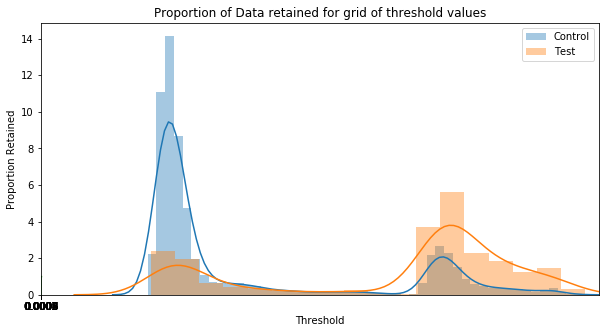

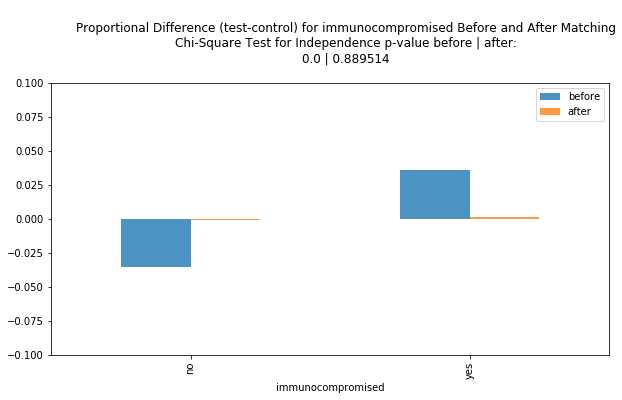

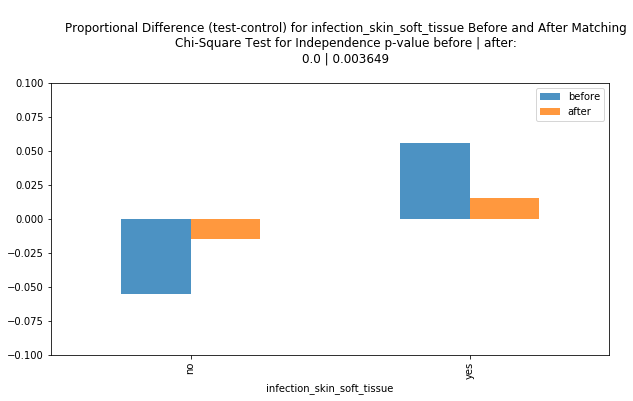

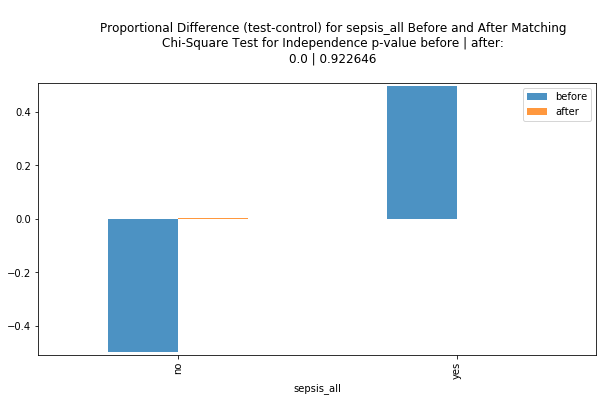

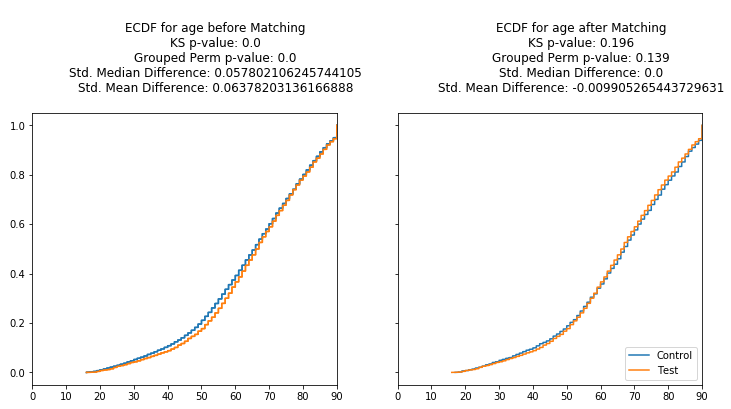

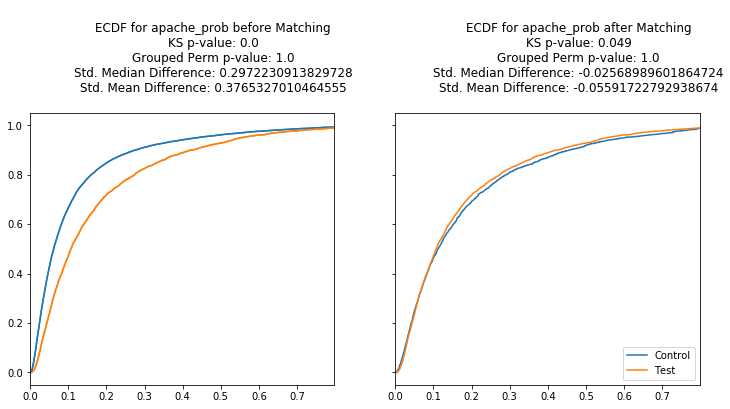

In [48]:
# INITIAL VANCO vs. NO VANCO
novanco = df[(df['vanco_wk'] == 0) & (df['vanco_adm'] == 0)]
vanco = df[(df['vanco_adm'] == 1)]
m_primary = calculate_or(exposure=vanco, control=novanco, seed=12938)